In [3]:
import sys
print(sys.executable)

c:\Users\RISHIVEER YADAV\AppData\Local\Programs\Python\Python39\python.exe


# 4Q) The Crypto Detective
In this are asked to implement a descision tree from scratch so that we can help Richard differentiate between legit transactions from the suspicious ones.

In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score
import time
import graphviz

C:\Users\RISHIVEER YADAV\AppData\Local\Temp\ipykernel_16020\3694154690.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.13990581 -0.06468611 -0.0500724  ... -0.09391352 -0.09756695
 -0.09026009]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  datasets[key].iloc[:, 1:] = scaler.fit_transform(datasets[key].iloc[:, 1:]).astype(np.float64)
C:\Users\RISHIVEER YADAV\AppData\Local\Temp\ipykernel_16020\3694154690.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06568265 -0.17429115 -0.09482152 ... -0.17517415 -0.18135512
  0.51444566]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  datasets[key].iloc[:, 1:] = scaler.fit_transform(datasets[key].iloc[:, 1:]).astype(np.float64)
C:\Users\RISHIVEER YADAV\AppData\Local\Temp\ipykernel_16020\3694154690.py:21: Fu


Files loaded and preprocessed successfully!


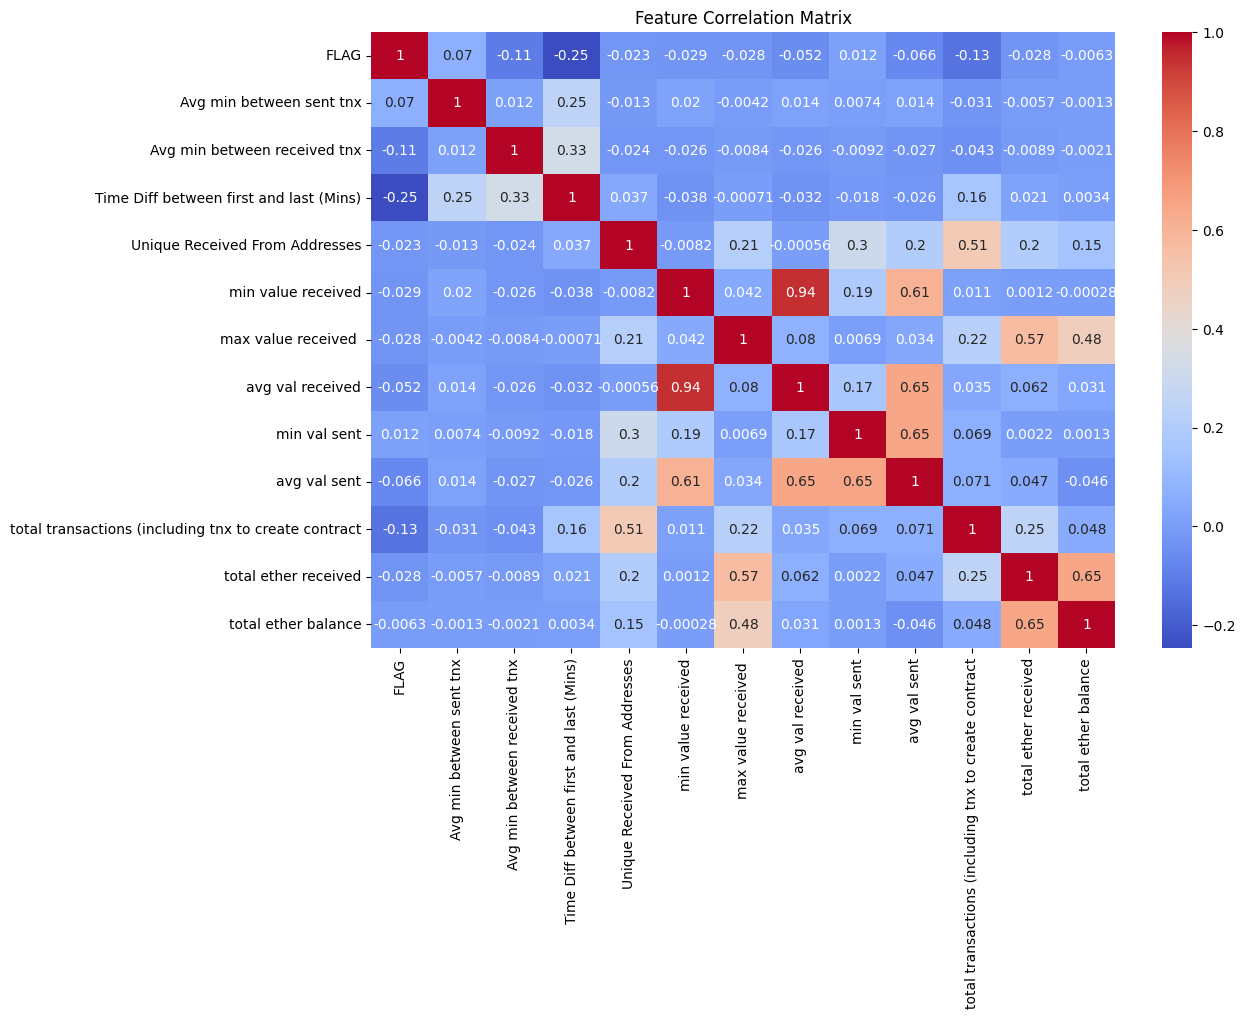

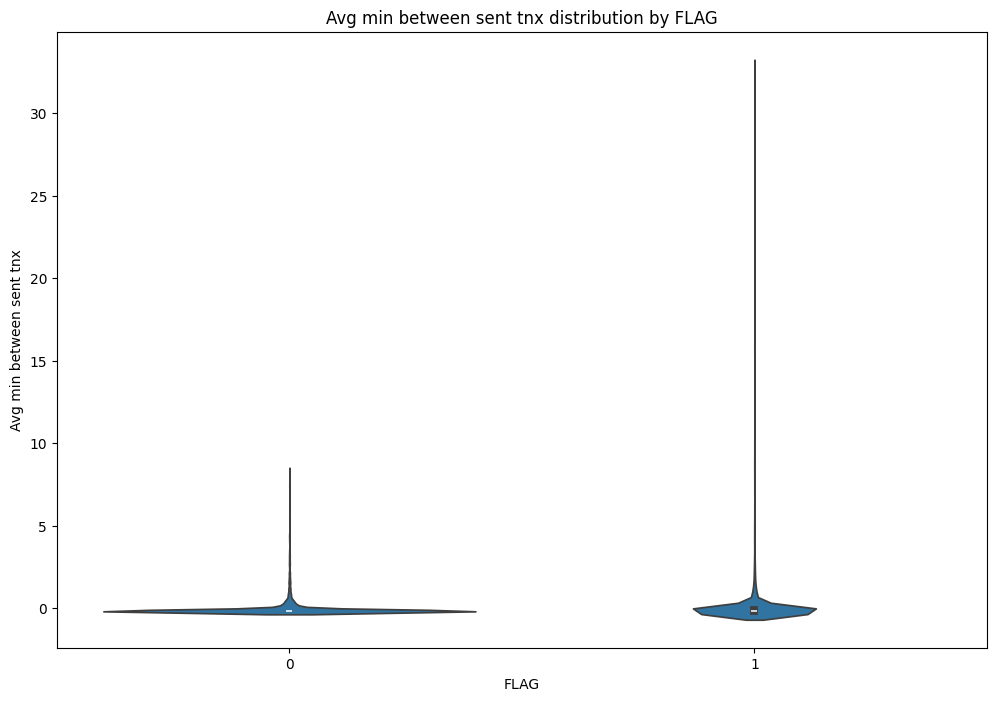

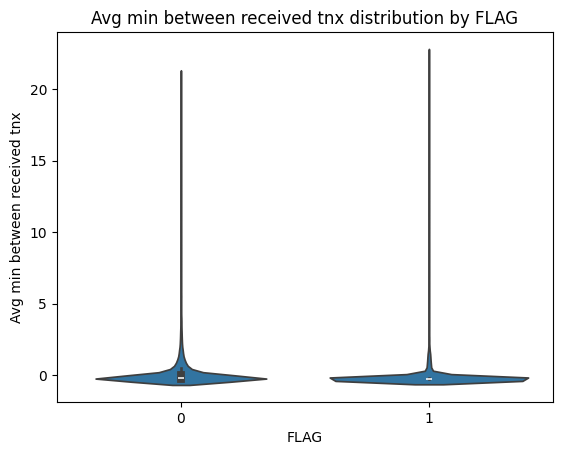

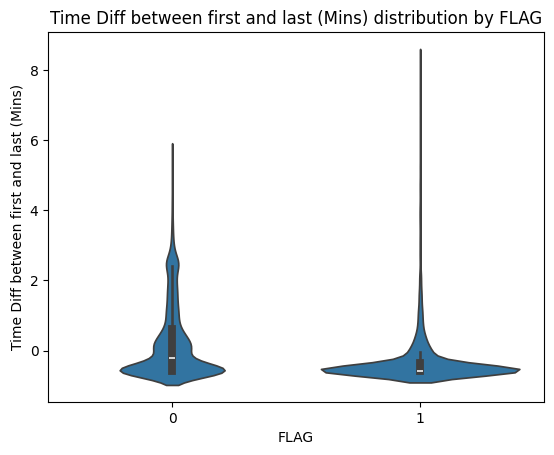

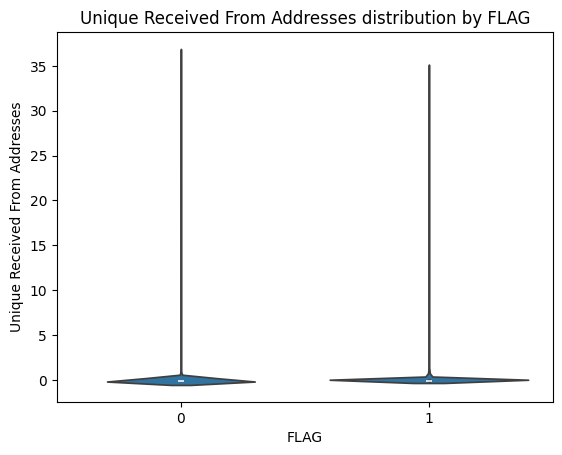

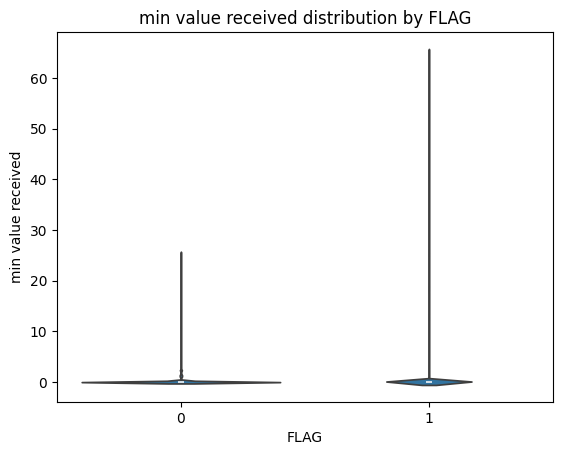

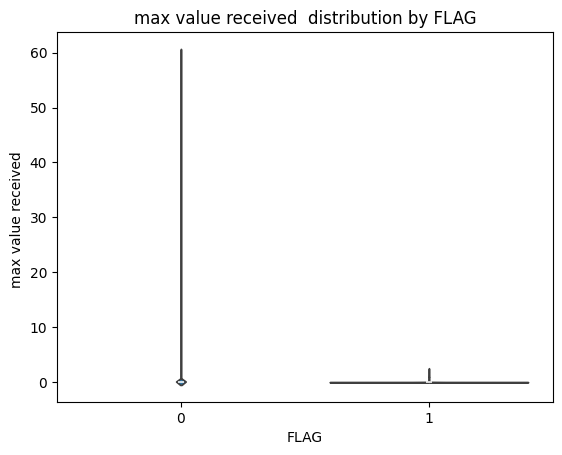

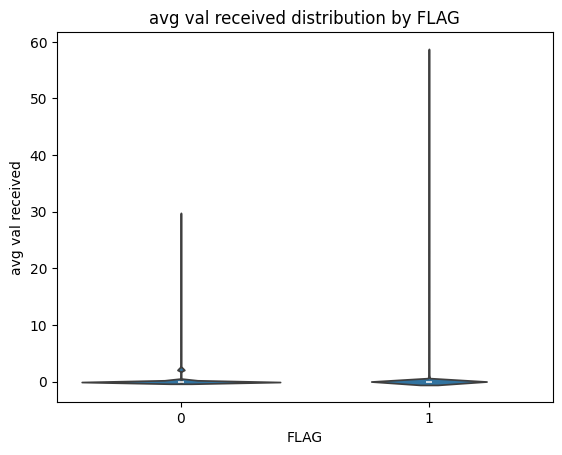

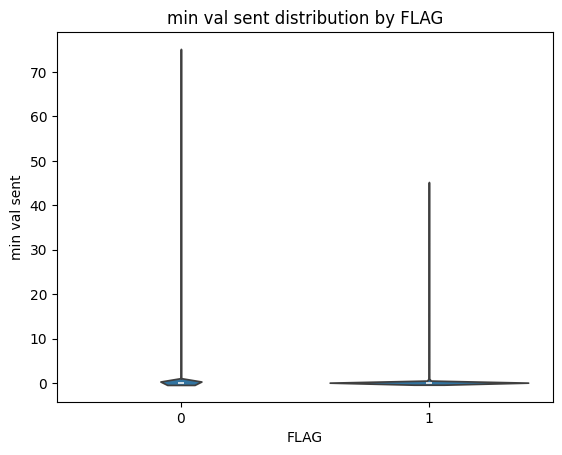

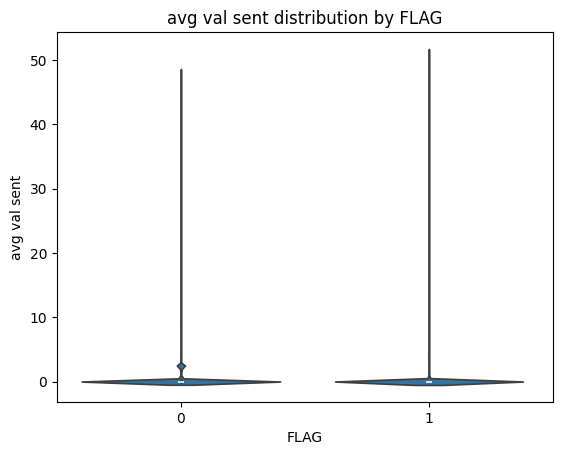

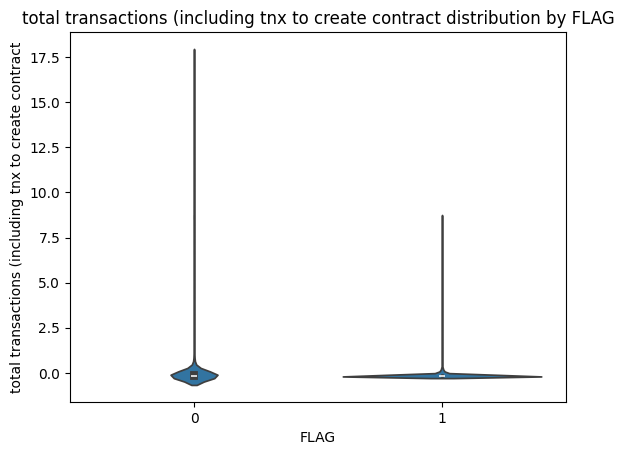

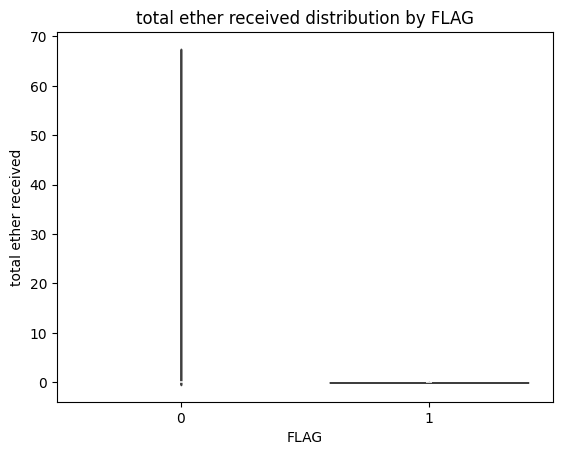

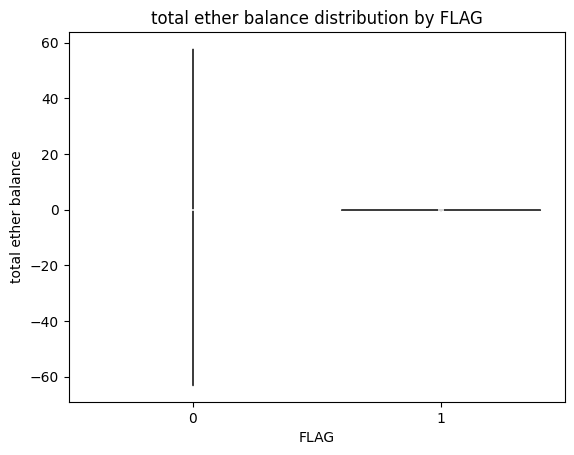

In [3]:
# Defining file paths
base_path = "./SMAI A1/SMAI'25-Assignment-1"
data_files = {
    "train": os.path.join(base_path, "train_data.csv"),
    "val": os.path.join(base_path, "val_data.csv"),
    "test": os.path.join(base_path, "test_data.csv")
}

datasets = {}

try:
    for key, path in data_files.items():
        df = pd.read_csv(path)
        df.drop(columns=["Address"], inplace=True)      # removing unnecessary fields
        df.fillna(df.median(), inplace=True)            # taking care of missing values by substituting the respective median values
        datasets[key] = df
    
    # scaling the feartures in order to normallize the numerical values so that they have comparable ranges
    scaler = StandardScaler()
    for key in datasets:
        datasets[key].iloc[:, 1:] = scaler.fit_transform(datasets[key].iloc[:, 1:]).astype(np.float64)
    print()
    print('Files loaded and preprocessed successfully!')
except Exception as e:
    print('Error loading the files:', e)


# Correlation Matrix
plt.figure(figsize=(12,8))
sns.heatmap(datasets['train'].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Violin Plot for Fraud vs Safe transactions
plt.figure(figsize=(12, 8))
for col in datasets['train'].columns[1:]:
    sns.violinplot(x=datasets['train']['FLAG'], y=datasets['train'][col])
    plt.title(f"{col} distribution by FLAG")
    plt.show()

#### Observations on the basis of the correlation matrix
1) The values min_value_received and avg_val_received have a very high coorelation (0.94). This means that trascations with small minimum values tend to have low average vales as well.
2) max_value_received and total_ether_received have a pretty good correlation (0.57), meaning higher maximum transaction values coontribute significantly to the total received amount
3) avg val received and total ether received show a 0.65 correlation, implying that accounts with a high average received value tend to have higher total received amounts.
4) FLAG and shows a negative correlation with the field between_first_and_last(mins) (-0.25). This implies that fradulent accounts lead to have more frequent transactions within a shorter time frame
5) 

Let us first create a class called DecisionTree. We shall also create 'train' function to train our data and a 'predict' function to predict an output

In [28]:
# Decision Tree Classifier
class DecisionTree():
    def __init__(self, max_depth=4, min_samples_split=2, min_samples_leaf=1, min_information_gain=0.0, criterion='entropy'):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.min_information_gain = min_information_gain
        self.criterion = criterion
        self.root = None

    def entropy(self, y):
        counts = np.bincount(y.astype(int))
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    def gini(self, y):
        counts = np.bincount(y.astype(int))
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities**2)

    def impurity(self, y):
        return self.entropy(y) if self.criterion == "entropy" else self.gini(y)

    def partition_impurity(self, subsets):
        total_size = sum(len(subset) for subset in subsets)
        return sum(self.impurity(subset) * len(subset) / total_size for subset in subsets)

    def split(self, data, feature_idx, feature_val):
        left = data[data[:, feature_idx] <= feature_val]
        right = data[data[:, feature_idx] > feature_val]
        return left, right

    def find_best_split(self, data):
        min_impurity = float("inf")
        best_feature = None
        best_value = None
        best_splits = None

        for feature_idx in range(data.shape[1] - 1):
            threshold = np.median(data[:, feature_idx])
            left, right = self.split(data, feature_idx, threshold)
            if len(left) == 0 or len(right) == 0:
                continue
            impurity = self.partition_impurity([left[:, -1], right[:, -1]])
            if impurity < min_impurity:
                min_impurity = impurity
                best_feature = feature_idx
                best_value = threshold
                best_splits = (left, right)

        return best_splits, best_feature, best_value, min_impurity

    def build_tree(self, data, depth=0):
        labels = data[:, -1]
        unique_labels = np.unique(labels, return_counts=True)
        probs = unique_labels[1] / len(labels)
        node_impurity = self.impurity(labels)
        
        if depth >= self.max_depth or len(labels) <= self.min_samples_leaf or node_impurity == 0:
            return TreeNode(data, None, None, probs, 0)
        
        (left, right), best_feature, best_value, min_impurity = self.find_best_split(data)
        
        if min_impurity > node_impurity - self.min_information_gain:
            return TreeNode(data, None, None, probs, 0)
        
        node = TreeNode(data, best_feature, best_value, probs, node_impurity - min_impurity)
        node.left = self.build_tree(left, depth + 1)
        node.right = self.build_tree(right, depth + 1)
        
        return node

    def fit(self, X, y):
        data = np.column_stack((X, y))
        self.root = self.build_tree(data)

    def predict_sample(self, node, sample):
        if node.feature_idx is None:
            return np.argmax(node.prediction_probs)
        if sample[node.feature_idx] <= node.feature_val:
            return self.predict_sample(node.left, sample)
        else:
            return self.predict_sample(node.right, sample)

    def predict(self, X):
        return np.array([self.predict_sample(self.root, sample) for sample in X])

class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain):
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.left = None
        self.right = None

# Split Data
X = datasets['train'].drop(columns=['FLAG']).values
y = datasets['train']['FLAG'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 71.96%


## 4.2) Fraud Detection Model
Now we are asked to compare different performance metrics of the custom made DecisionTree() and the readily available Scikit-Learn's DecisionTreeClassifier() such as their respective accuracies, computation time. 

In [29]:
# Training custom decision tree
start_time = time.time()
custom_tree = DecisionTree(max_depth=5, criterion='entropy')
custom_tree.fit(X_train, y_train)
custom_time = time.time() - start_time

# Prediction with custom model
y_predicted_custom = custom_tree.predict(X_test)
custom_accuracy = accuracy_score(y_test, y_predicted_custom)

# Training Scikit-Learn Decision Tree
start_time = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_time = time.time() - start_time

# Prediction with Scikit-Learn Model
y_prediction_sklearn = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, y_prediction_sklearn)

# Comparing results
print(f"Custom Decision Tree Accuracy: {custom_accuracy * 100:.2f}%")
print(f"Scikit-Learn Decision Tree Accuracy: {sklearn_accuracy * 100:.2f}%")
print(f"Custom Decision Tree Training Time: {custom_time:.4f} seconds")
print(f"Scikit-Learn Decision Tree Training Time: {sklearn_time:.4f} seconds")

Custom Decision Tree Accuracy: 71.96%
Scikit-Learn Decision Tree Accuracy: 82.95%
Custom Decision Tree Training Time: 0.0451 seconds
Scikit-Learn Decision Tree Training Time: 0.0383 seconds


Clearly, we see that the Scikit-Learn model is significantly better than our custom made one. One main reason could be because our model might have a simpler feature selection (always splitting on median) as a parameter for node splitting. Sklearn's DecisionTreeClassifier might use better node splitting techniques. Also, we observe that the Scikit-Learn's model is faster than the custom made one.

# 4.3) Hyperparameter Tuning
In this question we are asked to explore key decision tree hyperparameters like maximum tree depth and minimum samples for split, and then we have to compare entropy and Gini impurity metrics. We are then asked to visualize the accuracy plots across different model configurations

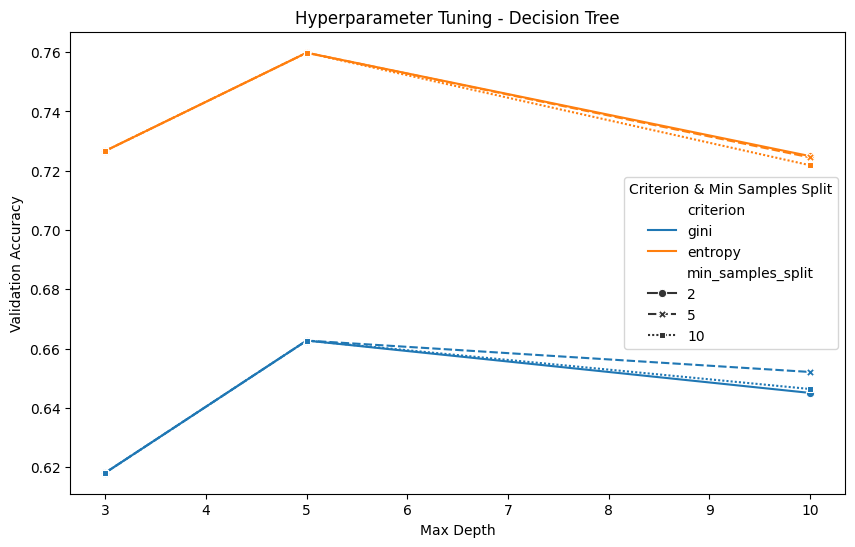

In [35]:

# parameters_grid = {
#     'max_depth': [3, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'criterion': ['gini', 'entropy']
# }

# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters_grid, cv=5, scoring='accuracy')
# X_train = datasets['train'].drop(columns=['FLAG']).values
# y_train = datasets['train']['FLAG'].values

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# # Plot Hyperparameter Tuning Results
# results = pd.DataFrame(grid_search.cv_results_)
# sns.lineplot(x=results['param_max_depth'], y=results['mean_test_score'], hue=results['param_criterion'])
# plt.xlabel("Max Depth")
# plt.ylabel("Accuracy")
# plt.title("Hyperparameter Tuning - Decision Tree")
# plt.show()


# Extract features and target variable
X_train = datasets['train'].drop(columns=['FLAG']).values
y_train = datasets['train']['FLAG'].values

X_val = datasets['val'].drop(columns=['FLAG']).values
y_val = datasets['val']['FLAG'].values

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Store results manually
results = []

for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for criterion in param_grid['criterion']:
            # Train model
            clf = DecisionTreeClassifier(max_depth=max_depth, 
                                         min_samples_split=min_samples_split, 
                                         criterion=criterion, 
                                         random_state=42)
            clf.fit(X_train, y_train)
            
            # Validate model
            val_accuracy = clf.score(X_val, y_val)
            
            # Store results
            results.append({'max_depth': max_depth, 
                            'min_samples_split': min_samples_split, 
                            'criterion': criterion, 
                            'val_accuracy': val_accuracy})

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Plot Hyperparameter Tuning Results
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='max_depth', y='val_accuracy', hue='criterion', style='min_samples_split', markers=True)
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning - Decision Tree")
plt.legend(title="Criterion & Min Samples Split")
plt.show()


##### Observations:
1) The validation accuracy improves as max depth increases from 3 to 5, but then starts to decline at depth 10. This suggests that a max depth of 5 is optimal, while deeper trees tend to overfit the training data, leading to reduced generalization on the validation set.
2) Also, entropy-based model consistently performs better than the Gini-based model across all depths. This indicates that entropy provides better splits for distinguishing fraudulent and non-fraudulent transactions in this dataset.
3) The validation accuracy does not change significantly across different min_samples_split values, suggesting that splitting at lower samples (like 2, 5, or 10) does not make a major difference in this case.

The reason for these results is a balance between underfitting and overfitting:
1) A very shallow tree (depth=3) lacks complexity, leading to underfitting.
2) A very deep tree (depth=10) captures noise and overfits.
3) The optimal depth (5) balances learning and generalization.

## 4.4) Model Visualization
In this part of the question we are asked to develop bar plots or color-coded charts to graphically represent feature contributions, highlightning the most influential predictors in the model. Also, we are aksed to create a graphical tree representation, revealing the model's decision-making structure

C:\Users\RISHIVEER YADAV\AppData\Local\Temp\ipykernel_16020\3532453128.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette='viridis')


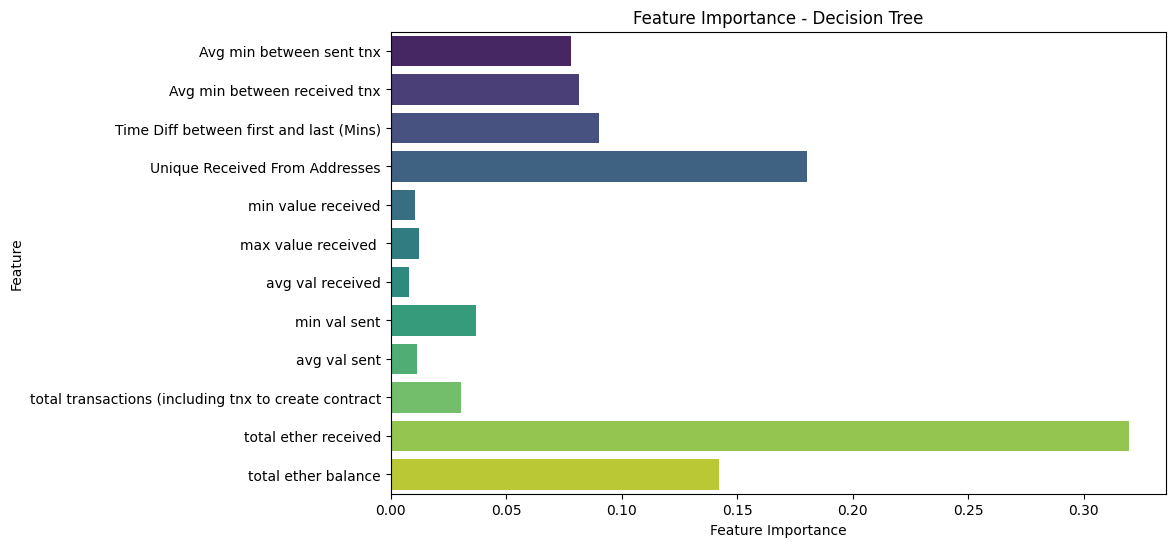

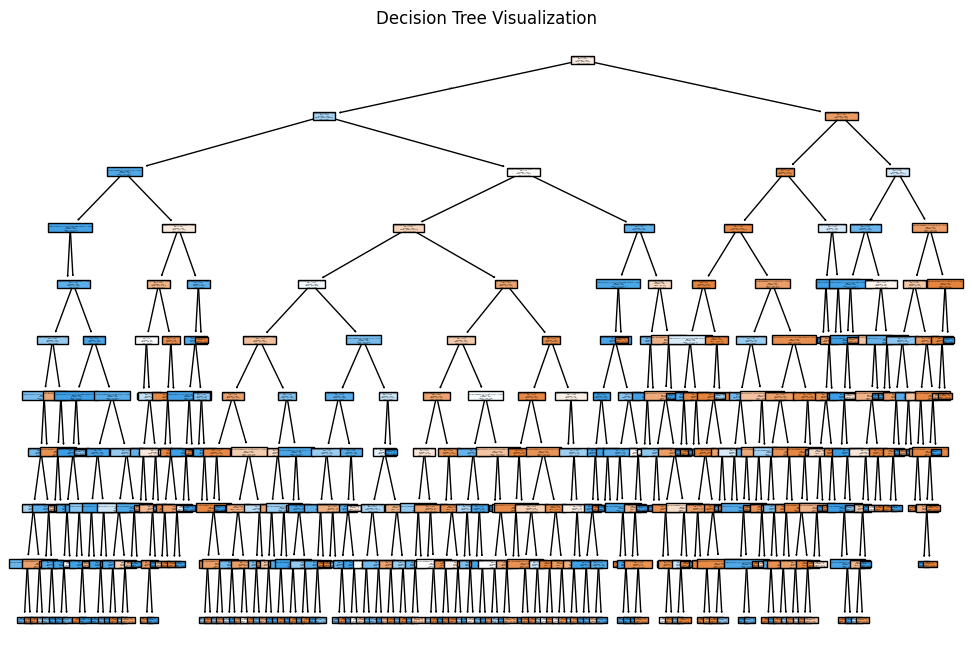

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [39]:
# Train the best decision tree with the optimal hyperparameters
best_tree = DecisionTreeClassifier(**best_params, random_state=42)
best_tree.fit(X_train, y_train)

# Feature Importance Visualization
feature_importances = best_tree.feature_importances_
feature_names = datasets['train'].drop(columns=['FLAG']).columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Decision Tree")
plt.show()

# Tree Visualization
plt.figure(figsize=(12, 8))
plot_tree(best_tree, feature_names=feature_names, class_names=["Not Fraud", "Fraud"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

# Generate a more detailed visualization using Graphviz
dot_data = export_graphviz(best_tree, out_file=None, feature_names=feature_names, class_names=["Not Fraud", "Fraud"], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves the tree as 'decision_tree.pdf'